# Notebook for anlaysing the structure of the social network.

This uses data from simulation batches run using release v1.0 of the model.

#### Note: in cass where a worker is replaced due to inactivity, but the worker is in the connected component of the social network, the worker is not removed from the network but instead persists throughout the simulation. Such workers/nodes are displayed in black below.

## TODO:
- plot and interpret excess degree distribution
- see how many prjects are being staffed on average (random case)

In [1]:
DATA_DIR = '../simulation_io/project_per_step_1_230521_v1.0/'
TS = 90

In [26]:
import pickle
import collections
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.approximation import large_clique_size, treewidth_min_degree
from scipy.stats import linregress
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import os, sys
MODEL_DIR = os.path.realpath(os.path.dirname('../superscript_model'))
sys.path.append(os.path.normpath(MODEL_DIR))
from superscript_model import model

In [3]:
sim_type = 'Basin_w_flex'

with open(DATA_DIR + sim_type + '/network_timestep_%d.gpickle' % TS, 'rb') as ifile:
    G = nx.read_gpickle(ifile) 
    
with open(DATA_DIR + sim_type + '/agents_vars_rep_9.pickle', 'rb') as ifile:
    agents = pickle.load(ifile) 
    agents = agents.loc[TS,:]
    agents['ovr_norm']= agents.ovr / np.max(agents.ovr)

In [4]:
#agents.xs(40, level='AgentID'). #Note: some nodes are not being removed after worker replacement.

With 2 projects per timetsep there is a strongly connected component and many isolated nodes:

In [5]:
def plot_network_coloured(G, agents, figsize=None, layout=None, weighted=False):
    nodes = G.nodes()
    colors = [float(agents.loc[n].ovr_norm) if n in agents.index else 0.0 for n in nodes]
    old_nodes = [n for n in nodes if n not in agents.index]

    if figsize is not None:
        plt.figure(figsize=figsize)
    if layout is not None:
        pos = layout(G)
    else:
        pos = nx.spring_layout(G)
        
    if weighted:
        edges = G.edges()
        weights = [G[u][v]['weight'] for u,v in edges]                  
        ec = nx.draw_networkx_edges(G, pos, width=weights)
    else:
        ec = nx.draw_networkx_edges(G, pos)
        
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, cmap='YlGnBu')
    nx.draw_networkx_nodes(G, pos, nodelist=old_nodes, node_color='k')

    cbar = plt.colorbar(nc)
    cbar.set_label('normalised OVR')
    plt.axis('off');

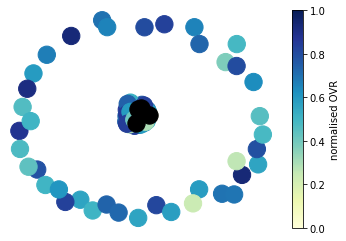

In [6]:
plot_network_coloured(G, agents)

In [7]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

There are many 'connected components' detected:

In [8]:
len(S)

41

But only one of these contains more than one node:

In [9]:
[len(si) for si in S if len(si) > 1]

[64]

This is the connected core of workers that have successfully collaborated on project:

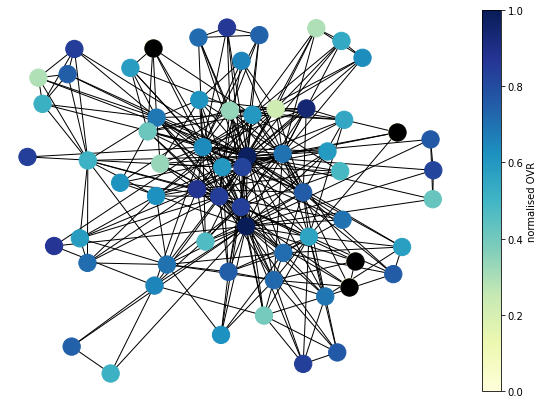

In [10]:
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))

plot_network_coloured(largest_cc, agents, figsize=(10,7))

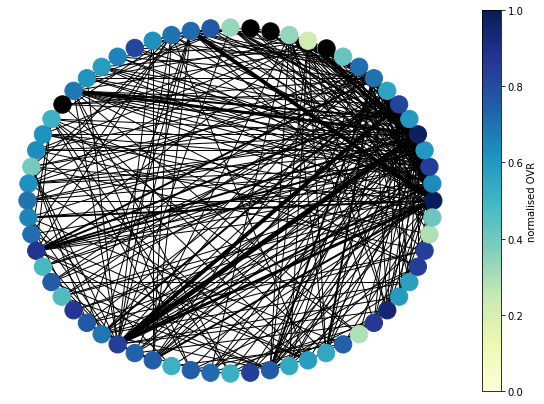

In [11]:
plot_network_coloured(largest_cc, agents, figsize=(10,7), layout=nx.circular_layout, weighted=True)

With 10 projects per timestep there are fewer isolates:

In [12]:
DATA_DIR = '../simulation_io/project_per_step_10_230521_v1.0/'
TS = 30

In [13]:
sim_type = 'Basin_w_flex'

with open(DATA_DIR + sim_type + '/network_timestep_%d.gpickle' % TS, 'rb') as ifile:
    G = nx.read_gpickle(ifile) 
    
with open(DATA_DIR + sim_type + '/agents_vars_rep_9.pickle', 'rb') as ifile:
    agents = pickle.load(ifile) 
    agents = agents.loc[TS,:]
    agents['ovr_norm']= agents.ovr / np.max(agents.ovr)

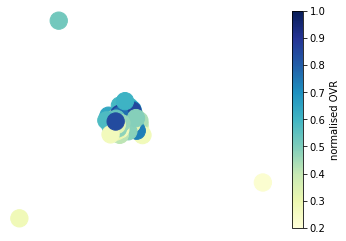

In [14]:
plot_network_coloured(G, agents)

In [15]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

Most of the workers are in the large connected component:

In [16]:
[len(si) for si in S if len(si) > 1]

[97]

This is the connected core of workers that have successfully collaborated on project:

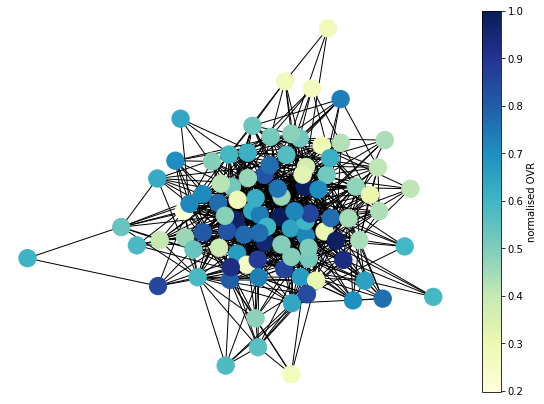

In [17]:
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
plot_network_coloured(largest_cc, agents, figsize=(10,7))

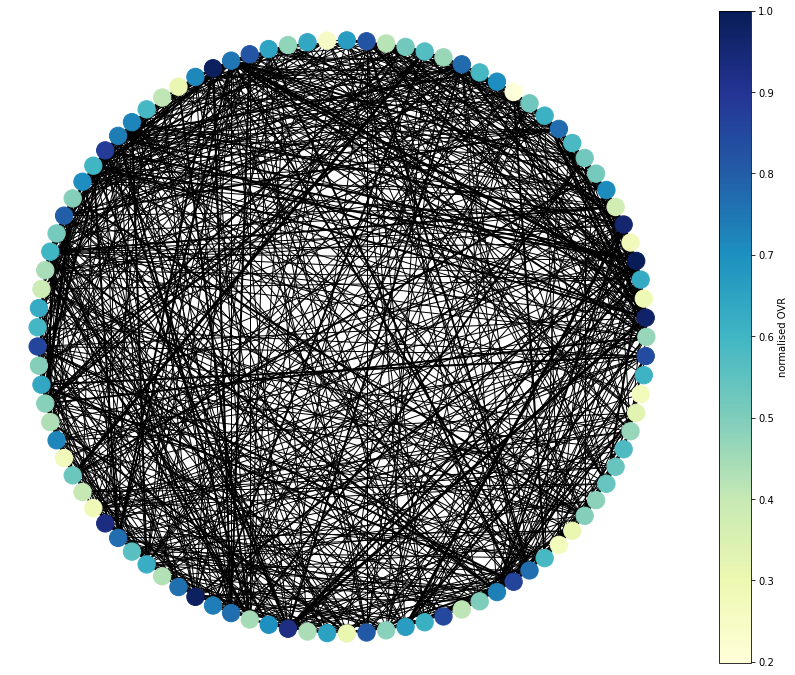

In [18]:
plot_network_coloured(largest_cc, agents, figsize=(15,12), layout=nx.circular_layout, weighted=True)

Text(0.5, 0, 'Degree')

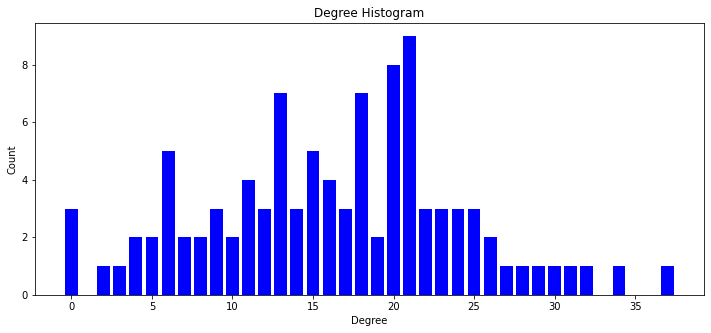

In [19]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig = plt.figure(figsize=(12,5))
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
#plt.xticks([d + 0.4 for d in deg])
#plt.xticklabels(deg);

#### There is a clear correlation between worker OVR and node degree, as we woulld expect:

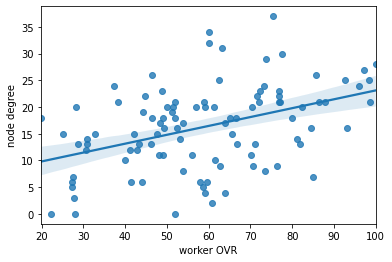

In [33]:
D = [d for n, d in G.degree()]
O = [float(agents.loc[n].ovr) if n in agents.index else -1.0 for n, d in G.degree()]
sns.regplot(x=O,y=D)
plt.xlabel('worker OVR')
plt.ylabel('node degree');

#### We now compute some standard network metrics:

In [22]:
def compute_network_metrics(network_dict, metric_dict=None):
    
    def load_net(n): 
        with open(n, 'rb') as ifile:
            return nx.read_gpickle(ifile) 
        
    network_dict = {
        key: load_net(network_dict[key])
        for key in network_dict.keys()
    }
    
    results = pd.DataFrame()
    results['network'] = network_dict.keys()
    
    if metric_dict is None:
        metric_dict = {
            
            'number_of_isolates': nx.algorithms.isolate.number_of_isolates,
            'number_of_edges': nx.classes.function.number_of_edges,
            'mean_degree': lambda x: np.mean(list(dict(nx.classes.function.degree(x)).values())),
            'density': nx.classes.function.density,
            'clustering_coefficient': nx.algorithms.cluster.average_clustering,
            'assortativity': nx.algorithms.assortativity.degree_assortativity_coefficient,
            'treewidth': lambda x: treewidth_min_degree(G)[0],
            'size_of_largest_connected_cpt': lambda x: nx.classes.function.number_of_nodes(x.subgraph(max(nx.connected_components(G), key=len))),
            'size_of_largest_clique': large_clique_size,
            'mean_excess_degree': lambda x: np.mean(list(nx.average_neighbor_degree(x).values())),
            'non-randomness_lcc': lambda x: nx.non_randomness(x.subgraph(max(nx.connected_components(x), key=len)))[0],
            'diameter_lcc': lambda x: nx.algorithms.distance_measures.diameter(x.subgraph(max(nx.connected_components(x), key=len)))
            
        }
        
    for metric in metric_dict.keys():
        results[metric] = [metric_dict[metric](G) for G in network_dict.values()]
    
    return results

In [23]:
TS = 90
sim_type = 'Basin_w_flex'

net_metrics = compute_network_metrics({
    'projects = 1': '../simulation_io/project_per_step_1_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 2': '../simulation_io/project_per_step_2_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 3': '../simulation_io/project_per_step_3_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 5': '../simulation_io/project_per_step_5_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,    
    'projects = 10': '../simulation_io/project_per_step_10_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
})

sim_type = 'Random'

net_metrics_random = compute_network_metrics({
    'projects = 1': '../simulation_io/project_per_step_1_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 2': '../simulation_io/project_per_step_2_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 3': '../simulation_io/project_per_step_3_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 5': '../simulation_io/project_per_step_5_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,    
    'projects = 10': '../simulation_io/project_per_step_10_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
})

In [24]:
net_metrics

,network,number_of_isolates,number_of_edges,mean_degree,density,clustering_coefficient,assortativity,treewidth,size_of_largest_connected_cpt,size_of_largest_clique,mean_excess_degree,non-randomness_lcc,diameter_lcc
0,projects = 1,40,339,6.519231,0.063294,0.483034,-0.214308,48,10,8,11.381181,29.286587,3
1,projects = 2,18,619,12.257426,0.122574,0.549992,-0.158910,48,22,10,19.693384,45.852332,3
2,projects = 3,5,885,17.700000,0.178788,0.603881,-0.154589,48,32,12,28.010421,56.836883,3
3,projects = 5,1,1466,29.320000,0.296162,0.573443,-0.077651,48,63,14,37.355688,84.293110,4
4,projects = 10,0,2480,49.600000,0.501010,0.557982,-0.028799,48,97,12,51.845567,85.068048,2


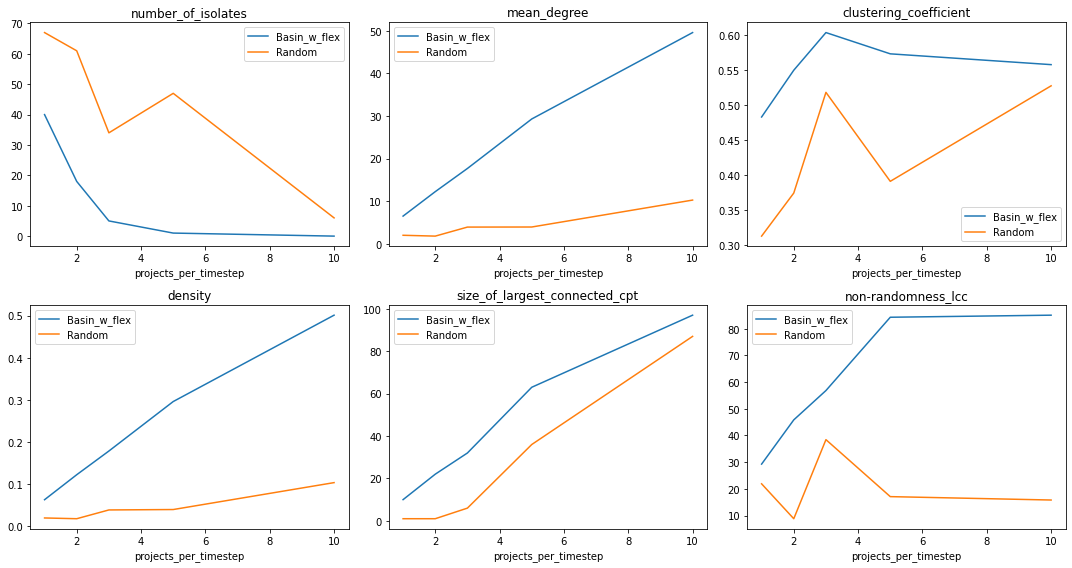

In [25]:
X = [1,2,3,5,10]

def splot(metric):    
    plt.plot(X, net_metrics[metric], label='Basin_w_flex')
    plt.plot(X, net_metrics_random[metric], label='Random')
    plt.legend()
    plt.xlabel('projects_per_timestep')
    plt.title(metric)
    
px = 2
py = 3
plt.figure(figsize=(15,8))
plt.subplot(px,py,1)
splot('number_of_isolates')
plt.subplot(px,py,2)
splot('mean_degree')
plt.subplot(px,py,3)
splot('clustering_coefficient')
plt.subplot(px,py,4)
splot('density')
plt.subplot(px,py,5)
splot('size_of_largest_connected_cpt')
plt.subplot(px,py,6)
splot('non-randomness_lcc')

plt.tight_layout()

#### Note: in the 'Random' case not all projects are being staffed because the random team allocation can lead to null-projects (e.g. project budget exceeded).